#### Here we are going to compare different Models using the test metric score to select the best model for more comprehensive hyperparamets  tunning.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

#load FashionMNIST dataset
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transforms)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)
train_size = int(0.8 * len(trainset))
validation_size = len(trainset) - train_size
train_dataset, validation_dataset = random_split(trainset, [train_size, validation_size])
trainloader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=4)
validationloader = DataLoader(validation_dataset, batch_size=20, shuffle=False, num_workers=4)
testloader = DataLoader(testset, batch_size=20, shuffle=False, num_workers=4)


In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


## 1. multilayer perceptron (MLP)

In [17]:
import time
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.layer_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layer_stack(x)
        return x



#enable GPU
model = SimpleNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)


#train
start_time = time.time()
epoch_losses = []
for epoch in range(100):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Calculate and store the average loss for this epoch
    avg_loss = running_loss / len(trainloader)
    epoch_losses.append(avg_loss)
    print(f'Epoch {epoch+1},  Loss: {avg_loss:.3f}')
end_time = time.time()
print('Finished Training')
total_training_time = end_time - start_time
print(f'Total Training Time: {total_training_time:.2f} seconds')

Epoch 1,  Loss: 1.194
Epoch 2,  Loss: 0.722
Epoch 3,  Loss: 0.633
Epoch 4,  Loss: 0.586
Epoch 5,  Loss: 0.555
Epoch 6,  Loss: 0.532
Epoch 7,  Loss: 0.515
Epoch 8,  Loss: 0.500
Epoch 9,  Loss: 0.488
Epoch 10,  Loss: 0.477
Epoch 11,  Loss: 0.468
Epoch 12,  Loss: 0.460
Epoch 13,  Loss: 0.452
Epoch 14,  Loss: 0.448
Epoch 15,  Loss: 0.440
Epoch 16,  Loss: 0.434
Epoch 17,  Loss: 0.429
Epoch 18,  Loss: 0.425
Epoch 19,  Loss: 0.420
Epoch 20,  Loss: 0.414
Epoch 21,  Loss: 0.411
Epoch 22,  Loss: 0.406
Epoch 23,  Loss: 0.402
Epoch 24,  Loss: 0.400
Epoch 25,  Loss: 0.396
Epoch 26,  Loss: 0.393
Epoch 27,  Loss: 0.389
Epoch 28,  Loss: 0.386
Epoch 29,  Loss: 0.383
Epoch 30,  Loss: 0.381
Epoch 31,  Loss: 0.378
Epoch 32,  Loss: 0.375
Epoch 33,  Loss: 0.371
Epoch 34,  Loss: 0.369
Epoch 35,  Loss: 0.367
Epoch 36,  Loss: 0.365
Epoch 37,  Loss: 0.362
Epoch 38,  Loss: 0.360
Epoch 39,  Loss: 0.358
Epoch 40,  Loss: 0.355
Epoch 41,  Loss: 0.353
Epoch 42,  Loss: 0.351
Epoch 43,  Loss: 0.351
Epoch 44,  Loss: 0.3

### Loss vs Epoch plot

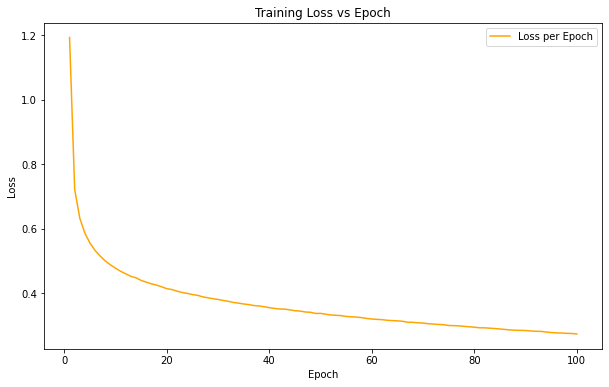

In [29]:
# Plotting the loss vs epoch
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, 101), epoch_losses, label='Loss per Epoch',color="orange")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch')
plt.legend()
plt.show()


### training Data Evalutation Metrics

In [22]:
model.eval()
from sklearn.metrics import classification_report, accuracy_score

y_pred= []
y_true=[]
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print(classification_report(y_true, y_pred, target_names=testset.classes, digits=3))

              precision    recall  f1-score   support

 T-shirt/top      0.850     0.894     0.872      4803
     Trouser      0.991     0.975     0.983      4762
    Pullover      0.856     0.850     0.853      4800
       Dress      0.897     0.920     0.909      4773
        Coat      0.819     0.888     0.852      4811
      Sandal      0.974     0.962     0.968      4832
       Shirt      0.830     0.713     0.767      4787
     Sneaker      0.946     0.953     0.950      4815
         Bag      0.972     0.971     0.972      4802
  Ankle boot      0.961     0.967     0.964      4815

    accuracy                          0.910     48000
   macro avg      0.910     0.910     0.909     48000
weighted avg      0.910     0.910     0.909     48000



### validtion data Evaluation Metrics

In [23]:
model.eval()
from sklearn.metrics import classification_report, accuracy_score

y_pred= []
y_true=[]
with torch.no_grad():
    for data in validationloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print(classification_report(y_true, y_pred, target_names=testset.classes, digits=3))

              precision    recall  f1-score   support

 T-shirt/top      0.811     0.855     0.833      1197
     Trouser      0.985     0.972     0.978      1238
    Pullover      0.805     0.792     0.799      1200
       Dress      0.892     0.892     0.892      1227
        Coat      0.774     0.848     0.809      1189
      Sandal      0.970     0.940     0.955      1168
       Shirt      0.756     0.658     0.704      1213
     Sneaker      0.935     0.946     0.940      1185
         Bag      0.957     0.965     0.961      1198
  Ankle boot      0.948     0.970     0.959      1185

    accuracy                          0.884     12000
   macro avg      0.883     0.884     0.883     12000
weighted avg      0.883     0.884     0.883     12000



### test data Evaluation Metrics

In [24]:
model.eval()
from sklearn.metrics import classification_report, accuracy_score

y_pred= []
y_true=[]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print(classification_report(y_true, y_pred, target_names=testset.classes, digits=3))

              precision    recall  f1-score   support

 T-shirt/top      0.820     0.858     0.839      1000
     Trouser      0.988     0.965     0.976      1000
    Pullover      0.798     0.796     0.797      1000
       Dress      0.861     0.890     0.875      1000
        Coat      0.776     0.836     0.805      1000
      Sandal      0.959     0.935     0.947      1000
       Shirt      0.738     0.635     0.683      1000
     Sneaker      0.920     0.942     0.931      1000
         Bag      0.966     0.964     0.965      1000
  Ankle boot      0.948     0.957     0.952      1000

    accuracy                          0.878     10000
   macro avg      0.877     0.878     0.877     10000
weighted avg      0.877     0.878     0.877     10000



### Confusion Matrix

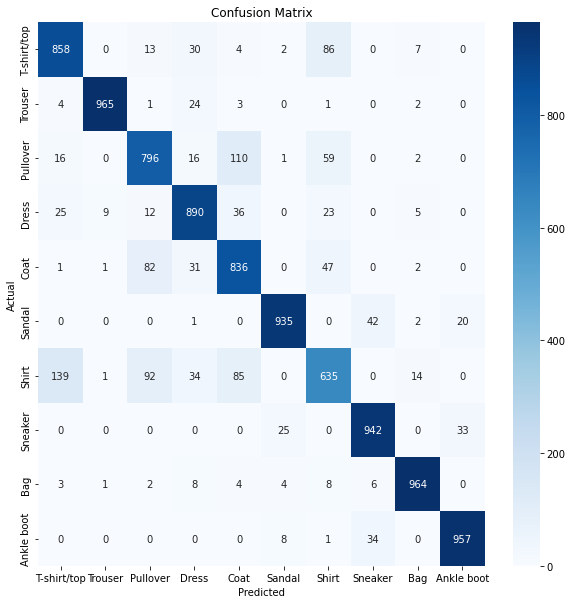

In [25]:
import torch
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Your model evaluation code remains the same...

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualization of the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=testset.classes, yticklabels=testset.classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


# 2. Support Vector Machine


In [6]:
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

X_train = trainset.data.numpy().reshape((trainset.data.shape[0], -1))
y_train = trainset.targets.numpy()
X_test = testset.data.numpy().reshape((testset.data.shape[0], -1))
y_test = testset.targets.numpy()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
clf = svm.SVC(gamma='scale')
clf.fit(X_train, y_train)

y_pred_val = clf.predict(X_val)
print(classification_report(y_val, y_pred_val))

# Test svm
y_pred_test = clf.predict(X_test)
print(classification_report(y_test, y_pred_test, target_names=testset.classes, digits=3))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84      1202
           1       0.99      0.97      0.98      1219
           2       0.83      0.83      0.83      1205
           3       0.86      0.92      0.89      1184
           4       0.82      0.85      0.83      1202
           5       0.97      0.96      0.96      1211
           6       0.75      0.66      0.70      1218
           7       0.94      0.96      0.95      1159
           8       0.95      0.97      0.96      1197
           9       0.97      0.96      0.96      1203

    accuracy                           0.89     12000
   macro avg       0.89      0.89      0.89     12000
weighted avg       0.89      0.89      0.89     12000

              precision    recall  f1-score   support

 T-shirt/top      0.818     0.852     0.834      1000
     Trouser      0.996     0.959     0.977      1000
    Pullover      0.793     0.815     0.804      1000
       Dress      0.862 

# 3. Random Forest

In [7]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred_val = clf.predict(X_val)
print(classification_report(y_val, y_pred_val))
y_pred_test = clf.predict(X_test)
print(classification_report(y_test, y_pred_test, target_names=testset.classes, digits=3))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1202
           1       1.00      0.97      0.98      1219
           2       0.79      0.82      0.80      1205
           3       0.87      0.91      0.89      1184
           4       0.77      0.83      0.80      1202
           5       0.97      0.96      0.97      1211
           6       0.75      0.60      0.67      1218
           7       0.94      0.94      0.94      1159
           8       0.96      0.97      0.96      1197
           9       0.95      0.96      0.95      1203

    accuracy                           0.88     12000
   macro avg       0.88      0.88      0.88     12000
weighted avg       0.88      0.88      0.88     12000

              precision    recall  f1-score   support

 T-shirt/top      0.818     0.852     0.834      1000
     Trouser      0.994     0.956     0.975      1000
    Pullover      0.767     0.802     0.784      1000
       Dress      0.869 

# 4. k-Nearest Neighbors (kNN)


In [8]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=3)

clf.fit(X_train, y_train)
y_pred_val = clf.predict(X_val)
print(classification_report(y_val, y_pred_val))
y_pred_test = clf.predict(X_test)
print(classification_report(y_test, y_pred_test, target_names=testset.classes, digits=3))

              precision    recall  f1-score   support

           0       0.75      0.86      0.80      1202
           1       0.99      0.97      0.98      1219
           2       0.74      0.80      0.77      1205
           3       0.88      0.86      0.87      1184
           4       0.78      0.75      0.77      1202
           5       0.99      0.85      0.91      1211
           6       0.66      0.59      0.62      1218
           7       0.89      0.96      0.92      1159
           8       0.98      0.93      0.95      1197
           9       0.90      0.97      0.93      1203

    accuracy                           0.85     12000
   macro avg       0.86      0.85      0.85     12000
weighted avg       0.85      0.85      0.85     12000

              precision    recall  f1-score   support

 T-shirt/top      0.746     0.844     0.792      1000
     Trouser      0.980     0.967     0.973      1000
    Pullover      0.725     0.791     0.757      1000
       Dress      0.896 

# 5. Gradient Boosting Machines (GBM)

In [10]:
from xgboost import XGBClassifier

clf = XGBClassifier()
clf.fit(X_train, y_train)
y_pred_val = clf.predict(X_val)
print(classification_report(y_val, y_pred_val))
y_pred_test = clf.predict(X_test)
print(classification_report(y_test, y_pred_test, target_names=testset.classes, digits=3))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1202
           1       1.00      0.98      0.99      1219
           2       0.83      0.85      0.84      1205
           3       0.89      0.92      0.91      1184
           4       0.83      0.84      0.84      1202
           5       0.98      0.97      0.98      1211
           6       0.77      0.69      0.73      1218
           7       0.96      0.96      0.96      1159
           8       0.98      0.97      0.97      1197
           9       0.97      0.97      0.97      1203

    accuracy                           0.90     12000
   macro avg       0.90      0.90      0.90     12000
weighted avg       0.90      0.90      0.90     12000

              precision    recall  f1-score   support

 T-shirt/top      0.827     0.863     0.844      1000
     Trouser      0.995     0.971     0.983      1000
    Pullover      0.793     0.821     0.807      1000
       Dress      0.899 

# 6. Exploring Neural Network more (Convolutional Neural Networks)


In [30]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time




class ComplexFashionMNISTNet2(nn.Module):
    def __init__(self):
        super(ComplexFashionMNISTNet2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(256,256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = self.avgpool(x)  
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.RandomErasing()
])





#enable GPU
model = ComplexFashionMNISTNet2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

start_time = time.time()
#train
epoch_losses = []

for epoch in range(100):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # Calculate and store the average loss for this epoch
    avg_loss = running_loss / len(trainloader)
    epoch_losses.append(avg_loss)
    print(f'Epoch {epoch+1},  Loss: {avg_loss:.3f}')

end_time = time.time()

# Calculate the total training time
total_training_time = end_time - start_time

print('Finished Training')
print(f'Total Training Time: {total_training_time:.2f} seconds')

Epoch 1,  Loss: 2.303
Epoch 2,  Loss: 2.302
Epoch 3,  Loss: 2.116
Epoch 4,  Loss: 1.113
Epoch 5,  Loss: 0.765
Epoch 6,  Loss: 0.641
Epoch 7,  Loss: 0.566
Epoch 8,  Loss: 0.503
Epoch 9,  Loss: 0.457
Epoch 10,  Loss: 0.413
Epoch 11,  Loss: 0.382
Epoch 12,  Loss: 0.359
Epoch 13,  Loss: 0.334
Epoch 14,  Loss: 0.317
Epoch 15,  Loss: 0.303
Epoch 16,  Loss: 0.290
Epoch 17,  Loss: 0.276
Epoch 18,  Loss: 0.265
Epoch 19,  Loss: 0.254
Epoch 20,  Loss: 0.248
Epoch 21,  Loss: 0.238
Epoch 22,  Loss: 0.230
Epoch 23,  Loss: 0.219
Epoch 24,  Loss: 0.212
Epoch 25,  Loss: 0.203
Epoch 26,  Loss: 0.196
Epoch 27,  Loss: 0.190
Epoch 28,  Loss: 0.183
Epoch 29,  Loss: 0.177
Epoch 30,  Loss: 0.171
Epoch 31,  Loss: 0.161
Epoch 32,  Loss: 0.157
Epoch 33,  Loss: 0.151
Epoch 34,  Loss: 0.144
Epoch 35,  Loss: 0.139
Epoch 36,  Loss: 0.134
Epoch 37,  Loss: 0.128
Epoch 38,  Loss: 0.121
Epoch 39,  Loss: 0.116
Epoch 40,  Loss: 0.110
Epoch 41,  Loss: 0.109
Epoch 42,  Loss: 0.099
Epoch 43,  Loss: 0.095
Epoch 44,  Loss: 0.0

Loss vs Epoch

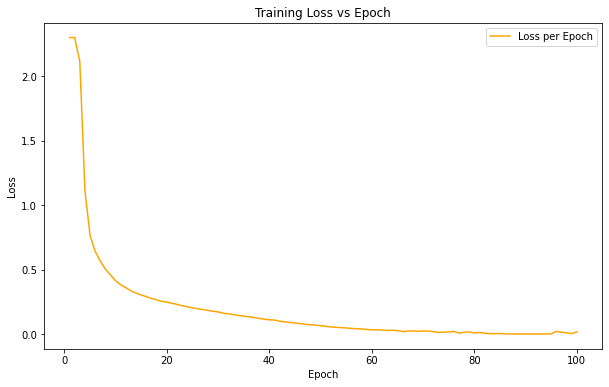

In [32]:
# Plotting the loss vs epoch
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, 101), epoch_losses, label='Loss per Epoch',color="orange")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch')
plt.legend()
plt.show()


Train data set metrics

In [33]:
model.eval()
from sklearn.metrics import classification_report, accuracy_score

y_pred= []
y_true=[]
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print(classification_report(y_true, y_pred, target_names=testset.classes, digits=3))

              precision    recall  f1-score   support

 T-shirt/top      1.000     0.983     0.991      4803
     Trouser      1.000     0.999     0.999      4762
    Pullover      0.986     0.993     0.989      4800
       Dress      0.997     0.997     0.997      4773
        Coat      0.947     1.000     0.973      4811
      Sandal      1.000     0.994     0.997      4832
       Shirt      0.989     0.942     0.965      4787
     Sneaker      0.998     0.998     0.998      4815
         Bag      0.999     1.000     0.999      4802
  Ankle boot      0.994     1.000     0.997      4815

    accuracy                          0.991     48000
   macro avg      0.991     0.991     0.991     48000
weighted avg      0.991     0.991     0.991     48000



Validation data set metrics

In [34]:
model.eval()
from sklearn.metrics import classification_report, accuracy_score

y_pred= []
y_true=[]
with torch.no_grad():
    for data in validationloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print(classification_report(y_true, y_pred, target_names=testset.classes, digits=3))

              precision    recall  f1-score   support

 T-shirt/top      0.914     0.819     0.864      1197
     Trouser      0.993     0.985     0.989      1238
    Pullover      0.846     0.881     0.863      1200
       Dress      0.917     0.914     0.916      1227
        Coat      0.789     0.920     0.849      1189
      Sandal      0.993     0.966     0.979      1168
       Shirt      0.795     0.721     0.756      1213
     Sneaker      0.965     0.955     0.960      1185
         Bag      0.982     0.982     0.982      1198
  Ankle boot      0.945     0.982     0.963      1185

    accuracy                          0.912     12000
   macro avg      0.914     0.913     0.912     12000
weighted avg      0.914     0.912     0.912     12000



### test data evaluation metric

In [35]:
model.eval()
from sklearn.metrics import classification_report, accuracy_score

y_pred= []
y_true=[]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print(classification_report(y_true, y_pred, target_names=testset.classes, digits=3))

              precision    recall  f1-score   support

 T-shirt/top      0.906     0.799     0.849      1000
     Trouser      0.995     0.982     0.988      1000
    Pullover      0.830     0.872     0.851      1000
       Dress      0.912     0.912     0.912      1000
        Coat      0.770     0.906     0.833      1000
      Sandal      0.989     0.965     0.977      1000
       Shirt      0.769     0.686     0.725      1000
     Sneaker      0.961     0.967     0.964      1000
         Bag      0.974     0.983     0.979      1000
  Ankle boot      0.959     0.980     0.969      1000

    accuracy                          0.905     10000
   macro avg      0.907     0.905     0.905     10000
weighted avg      0.907     0.905     0.905     10000



### Confusion Matrix

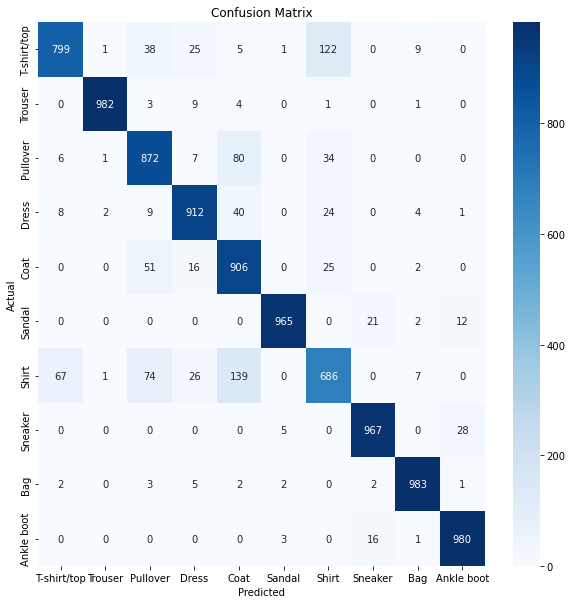

In [36]:
import torch
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Your model evaluation code remains the same...

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualization of the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=testset.classes, yticklabels=testset.classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


##### after comapring the test results from different models CNN has the best preformace. Further exploration of the Model is Needed i.e exploring deeper CNN Models and other Hyperparameters for better results